In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *
import pandas as pd
import numpy as np
import cv2

from efficientnet_pytorch import EfficientNet

In [2]:
class_boundaries = np.array([0.2655,0.3481,0.6782,0.7772])
class_centres = np.zeros(class_boundaries.shape[0]+1)
class_centres[0] = class_boundaries[0]/2
for i in range(1,class_boundaries.shape[0]):
    class_centres[i] = (class_boundaries[i]+class_boundaries[i-1])/2
class_centres[-1] = (1+class_boundaries[-1])/2
class_centres

array([0.13275, 0.3068 , 0.51315, 0.7277 , 0.8886 ])

In [3]:
df = pd.read_csv('../Data/Old_data/UnimodalLabels.csv').fillna('')#.iloc[:100,:]

In [4]:
old_stats = ([0.7229, 0.6502, 0.6050], [0.1622, 0.1431, 0.1128])
def get_data(size=224,bs=32):
    np.random.seed(420)
    
    tfms = [[rotate(degrees=(-5,5),p=0.5),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.5)],[]]
    tfms[0].extend(rand_resize_crop(size,max_scale=2))
    
    data = ImageDataBunch.from_df(
        '../Data/Old_data/train_processed',
        df,
        ds_tfms=tfms,
        size=size,
        bs = bs,
        label_delim = ',',
        valid_pct = 0.1,
        num_workers = os.cpu_count() 
    ).normalize(old_stats)
    
    return data

In [5]:
def get_class_stats():
    class_boundaries = torch.Tensor(np.array([0.2655,0.3481,0.6782,0.7772])).cuda()
    class_boundaries.requires_grad_(False)
    class_centres = torch.Tensor(np.array([0.13275, 0.3068 , 0.51315, 0.7277 , 0.8886 ])).cuda()
    class_centres.requires_grad_(False)
    return class_boundaries,class_centres

In [6]:
class OrdinalLoss(nn.Module):
    def __init__(self, phi):
        super().__init__()
        self.class_boundaries,self.class_centres = get_class_stats()
        self.phi = phi

    def forward(self, inputs, targets):
        # Classification error
        inputs = torch.sigmoid(inputs)
        inputs = inputs.reshape(inputs.shape[0],1)
        preds = (inputs-self.class_centres.reshape(1,self.class_centres.shape[0])).abs().argmin(-1)
        class_loss = torch.pow(self.phi,(targets.argmax(-1)-preds).abs().float()) - 1
        
        # Confidence error
        confidence_loss = torch.pow((self.class_centres[targets.argmax(-1)] - inputs.squeeze()),2)
         
        return (class_loss+confidence_loss).mean()

In [7]:
class ConfusionMatrixMultiClass(Callback):
    def on_train_begin(self, **kwargs):
        self.n_classes = 0
        self.class_boundaries, self.class_centres = get_class_stats()
        self.class_boundaries,self.class_centres = self.class_boundaries.cpu(),self.class_centres.cpu()

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        if self.n_classes == 0:
            self.n_classes = last_target.shape[-1]
            self.x = torch.arange(0, self.n_classes)  
        
        preds = torch.sigmoid(last_output).cpu()
        preds = (preds.reshape(preds.shape[0],1)-self.class_centres.reshape(1,self.class_centres.shape[0])).abs().argmin(-1)        
        targs = last_target.argmax(-1).cpu()
        
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm
        
@dataclass
class MultiKappaScore(ConfusionMatrixMultiClass):
    "Computes the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
#         raise ValueError()
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)

In [9]:
from fastai.basic_train import LearnerCallback
from fastai.basic_train import Learner

class ControlPhi(LearnerCallback):
    """Stops model after N iterations.
    Usage:
    stopper = partial(StopAfterNIterations, num_iterations = 17)
    learn = create_cnn(data, models.resnet18, callback_fns = [stopper])
    """
    def __init__(self, learn: Learner):
        super().__init__(learn)

    def on_epoch_end(self, **kwargs) ->bool:
        if kwargs['epoch'] <= 15//2:
            if kwargs['epoch']%2 == 0:
                learn.loss_func.phi *= 1.1
                print('Changing phi to: '+str(learn.loss_func.phi))
        else:
            if kwargs['epoch']%2 == 0:
                learn.loss_func.phi *= 0.95
                print('Changing phi to: '+str(learn.loss_func.phi))

In [10]:
class GradientAccumulator(LearnerCallback):
    """Accumulates gradients over N iterations
    Usage:
    accumulator = partial(GradientAccumulator, num_iterations=100)
    learn = create_cnn(data, models.resnet18, callback_fns = [accumulator])
    """
    def __init__(self, learn: Learner, num_iterations: int = 4, disable_callback: bool = False):
        """
        :param num_iterations: Accumulate gradients over `num_iterations` iterations before taking an optimizer step
        """
        super().__init__(learn)
        self.num_iterations = num_iterations
        self.skipped_last_backprop = False

    def on_backward_end(self, iteration, **kwargs) -> None:
        if (iteration % self.num_iterations != 0) or (iteration == 0):
            self.skipped_last_backprop = True
            return {'skip_step': True, 'skip_zero': True}
        else:
            self.skipped_last_backprop = False

    def on_step_end(self, **kwargs):
        if self.skipped_last_backprop:
            return {'skip_zero': True}

    def on_epoch_end(self, **kwargs) ->bool:
        """Deals with the edge case of an epoch ending"""
        if self.skipped_last_backprop:
            self.learn.opt.step()
            self.learn.opt.zero_grad()

In [20]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=1).cuda()
learn = Learner(get_data(416,16),
                model,
                wd=1e-5,
                callback_fns=[ShowGraph,
#                               OverSamplingCallback,
                              partial(SaveModelCallback, every='epoch', monitor='multi_kappa_score', name='epoch'),
                              partial(SaveModelCallback, every='improvement', monitor='multi_kappa_score', name='best_kappa', mode='max'),
                              ControlPhi,
                              partial(GradientAccumulator, num_iterations=2)
                             ],
                metrics=[accuracy_thresh,
                         MultiKappaScore('quadratic')
                        ],
                loss_func = OrdinalLoss(phi=1.6)
               )
learn.to_fp16()
learn.load('B4_Uni_224_25')
learn.unfreeze()

Loaded pretrained weights for efficientnet-b4


/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type OrdinalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
def do_fit(learner, epochs, lr, start_epoch=0, name='B4_Uni', res=224, bs=16, div=25):
    learner.data = get_data(size=res,bs=bs)
    learner.to_fp16()
    learner.fit_one_cycle(epochs, lr, pct_start=0.3, div_factor=div, start_epoch=start_epoch)
    learner.save(name+'_'+str(res)+'_'+str(start_epoch+epochs))
    print('Model saved as '+name+'_'+str(res)+'_'+str(start_epoch+epochs))

epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time
0,0.193028,0.193510,0.926638,0.698047,13:26
1,0.209603,0.224923,0.912963,0.640755,12:47
2,0.198463,0.222477,0.921866,0.657630,12:44
3,0.189329,0.201782,0.924573,0.681686,12:43
4,0.191570,0.197477,0.926211,0.665335,12:47
5,0.181613,0.191583,0.925783,0.731249,12:45
6,0.188769,0.177616,0.932835,0.752440,12:49
7,0.176690,0.174462,0.933832,0.759548,12:41
8,0.159183,0.169013,0.937678,0.776192,12:42
9,0.155691,0.167975,0.937607,0.769640,12:46


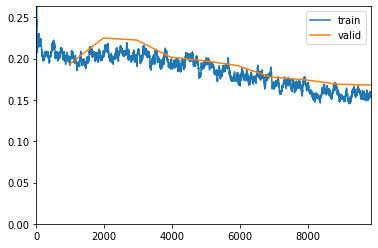

Better model found at epoch 0 with multi_kappa_score value: 0.6980466842651367.
Better model found at epoch 5 with multi_kappa_score value: 0.7312488555908203.
Better model found at epoch 6 with multi_kappa_score value: 0.7524401545524597.
Better model found at epoch 7 with multi_kappa_score value: 0.7595479488372803.
Better model found at epoch 8 with multi_kappa_score value: 0.7761918306350708.
Model saved as B4_224_10


In [10]:
do_fit(learn, 10, 3e-3, bs=32)

Loaded epoch_0
Model best_kappa_0 not found.


epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time
1,0.256612,0.236244,0.744273,0.702779,14:47
2,0.297559,0.310499,0.760171,0.662957,14:20
3,0.368996,0.485728,0.777949,0.530554,14:32
4,0.434789,0.446100,0.748889,0.720823,14:31
5,0.497267,0.533360,0.732820,0.756032,14:31
6,0.627223,0.635806,0.733675,0.760009,14:31
7,0.656644,0.830646,0.759316,0.719403,14:32
8,0.768920,0.933562,0.750598,0.749430,14:31


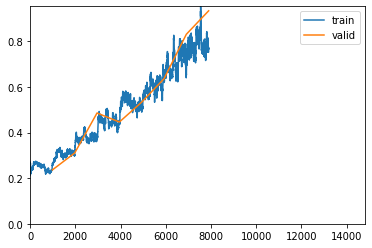

Better model found at epoch 1 with multi_kappa_score value: 0.7027788162231445.
Better model found at epoch 4 with multi_kappa_score value: 0.7208234071731567.
Better model found at epoch 5 with multi_kappa_score value: 0.7560321092605591.
Better model found at epoch 6 with multi_kappa_score value: 0.7600090503692627.


KeyboardInterrupt: 

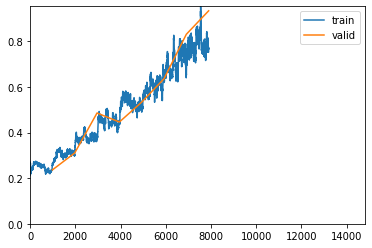

In [35]:
do_fit(learn, 15, 1e-3, bs=32, start_epoch=1)

In [ ]:
learn.load('epoch_8')

In [49]:
learn.callback_fns.pop(-1)
learn.callback_fns.append(ControlPhi)

In [50]:
learn.loss_func.phi = 2.455384

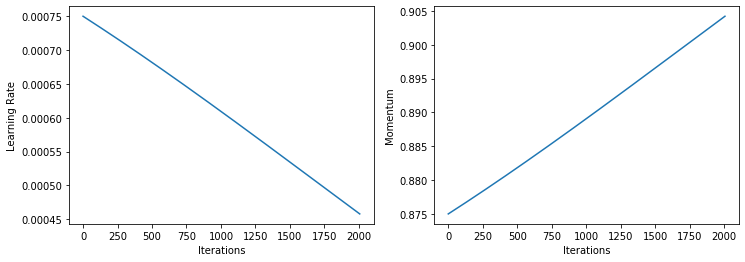

In [51]:
learn.recorder.plot_lr(show_moms=True)

Loaded epoch_7
Model best_kappa_7 not found.


epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time
8,0.547534,0.572553,0.739316,0.769294,14:29
9,0.341791,0.428940,0.733675,0.782164,14:31


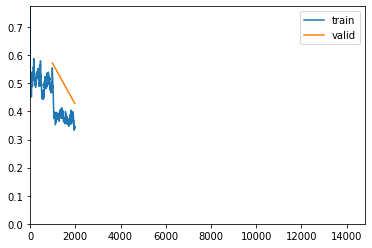

Better model found at epoch 8 with multi_kappa_score value: 0.7692937850952148.
Better model found at epoch 9 with multi_kappa_score value: 0.7821643352508545.


Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", 

KeyboardInterrupt: 

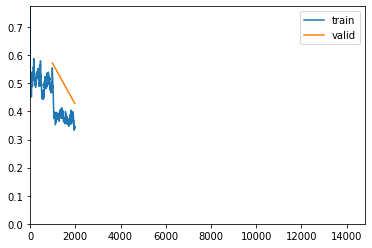

In [44]:
do_fit(learn, 15, 1e-3, bs=32, start_epoch=8)

Loaded epoch_9
Model best_kappa_9 not found.


epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time
10,0.436033,0.541447,0.740855,0.784505,14:29
11,0.410444,0.495879,0.735897,0.803735,14:32
12,0.374369,0.515136,0.737778,0.798729,14:33
13,0.284989,0.403815,0.734359,0.799021,14:32
14,0.291940,0.405782,0.732821,0.801819,14:33


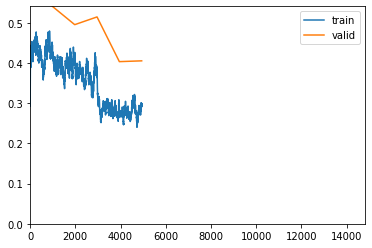

Better model found at epoch 10 with multi_kappa_score value: 0.7845050096511841.
Better model found at epoch 11 with multi_kappa_score value: 0.8037346601486206.
Reducing phi to: 2.2098456
Model saved as B4_Uni_224_25


In [52]:
do_fit(learn, 15, 1e-3, bs=32, start_epoch=10)

Changing phi to: 1.6940000000000002
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-07


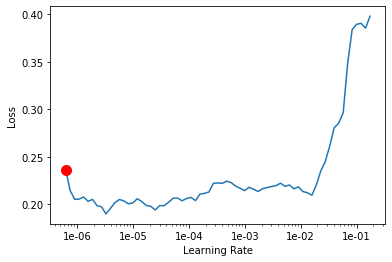

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [77]:
# learn.load('B4_224_3')
learn.fit(0, lr=0)

epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time


In [ ]:
learn.validate()

In [ ]:
%debug

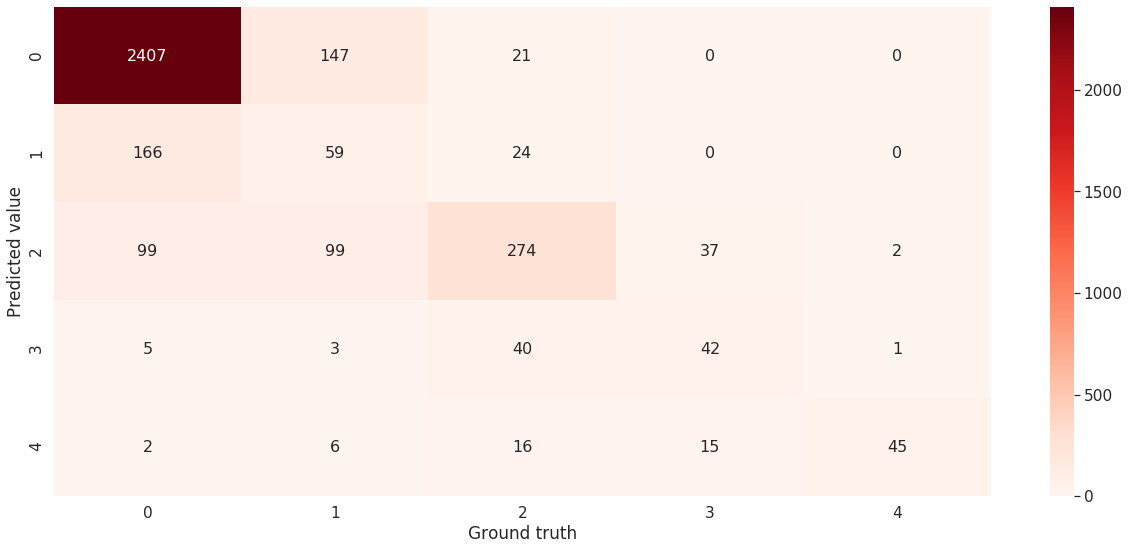

In [14]:
cm = np.array([
        [2.4070e+03, 1.4700e+02, 2.1000e+01, 0.0000e+00, 0.0000e+00],
        [1.6600e+02, 5.9000e+01, 2.4000e+01, 0.0000e+00, 0.0000e+00],
        [9.9000e+01, 9.9000e+01, 2.7400e+02, 3.7000e+01, 2.0000e+00],
        [5.0000e+00, 3.0000e+00, 4.0000e+01, 4.2000e+01, 1.0000e+00],
        [2.0000e+00, 6.0000e+00, 1.6000e+01, 1.5000e+01, 4.5000e+01]],dtype=np.int32)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
       
df_cm = pd.DataFrame(cm, range(5),range(5))
plt.figure(figsize = (21,9))

sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap='Reds',fmt='d')# font size

plt.xlabel("Ground truth")
plt.ylabel("Predicted value")

plt.show()
# cm

In [5]:
df_cm.head()

,0,1,2,3,4
0,2407,147,21,0,0
1,166,59,24,0,0
2,99,99,274,37,2
3,5,3,40,42,1
4,2,6,16,15,45


In [76]:
learn.metrics.pop(-1)
learn.metrics.append(MultiKappaScore('quadratic'))

In [78]:
learn.validate()

[0.15854903, tensor(0.7359), tensor(0.8037)]

## 416,416

epoch,train_loss,valid_loss,accuracy_thresh,multi_kappa_score,time
0,0.247623,0.223341,0.761881,0.701742,28:33
1,0.292381,0.253831,0.748718,0.756761,28:59
2,0.270730,0.235782,0.741710,0.784496,28:56
3,0.311924,0.285410,0.741710,0.798470,29:02
4,0.264610,0.275135,0.741881,0.808978,29:02
5,0.348088,0.337233,0.738803,0.816674,28:59
6,0.345620,0.329226,0.739145,0.819928,29:01
7,0.444740,0.408625,0.741709,0.820955,29:03
8,0.384350,0.402895,0.741709,0.823224,29:01
9,0.370993,0.358039,0.741026,0.822736,29:09


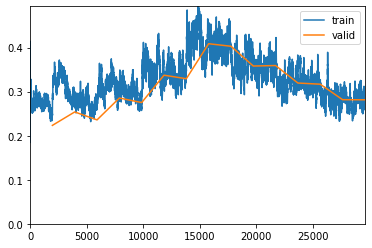

Better model found at epoch 0 with multi_kappa_score value: 0.7017415761947632.
Changing phi to: 1.7600000000000002
Better model found at epoch 1 with multi_kappa_score value: 0.7567606568336487.
Better model found at epoch 2 with multi_kappa_score value: 0.7844961285591125.
Changing phi to: 1.9360000000000004
Better model found at epoch 3 with multi_kappa_score value: 0.7984703183174133.
Better model found at epoch 4 with multi_kappa_score value: 0.8089778423309326.
Changing phi to: 2.1296000000000004
Better model found at epoch 5 with multi_kappa_score value: 0.8166738152503967.
Better model found at epoch 6 with multi_kappa_score value: 0.8199284076690674.
Changing phi to: 2.3425600000000006
Better model found at epoch 7 with multi_kappa_score value: 0.8209550976753235.
Better model found at epoch 8 with multi_kappa_score value: 0.8232238292694092.
Changing phi to: 2.2254320000000005
Changing phi to: 2.1141604000000003
Better model found at epoch 11 with multi_kappa_score value: 0.8

In [22]:
do_fit(learn, 15, 2e-5, res=448, bs=16)

In [23]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
!sudo shutdown -h 1